<h1 style="color: #00BFFF;">00 | Import Libraries</h1>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Basic Libraries
import os
import json
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Computer Vision
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


<h1 style="color: #00BFFF;">02 | Data Preprocessing</h1>

In [ ]:
# Data Path
dataset_path= '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/data'

In [ ]:
# Path for every folder
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
validation_dir = os.path.join(dataset_path, 'val')

<h2 style="color: #008080;">Data Cleaning</h2>

Cleaning data images from the dataset. Checking for **corrupted images** and deleting them.

In [ ]:
def remove_invalid_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                img_read = tf.io.read_file(fpath)
                img_2 = tf.image.decode_image(img_read)

            except tf.errors.InvalidArgumentError:
                print(f"Removing: {fpath}")
                os.remove(fpath)
                removed += 1
    print(f"Removed {removed} corrupted/invalid images from {folder_path}")

In [ ]:
# Check all your datasets
remove_invalid_images(os.path.join(train_dir, "fractured"))
remove_invalid_images(os.path.join(train_dir, "not fractured"))
remove_invalid_images(os.path.join(test_dir, "fractured"))
remove_invalid_images(os.path.join(test_dir, "not fractured"))
remove_invalid_images(os.path.join(validation_dir, "fractured"))
remove_invalid_images(os.path.join(validation_dir, "not fractured"))

<h2 style="color: #FF6347;">Preprocessing the Dataset</h2>

In [ ]:
# Define the image size and batch size
img_size = (160, 160)  # resize images
batch_size = 64

In [ ]:
# Load the training, validation, and test datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

Found 9239 files belonging to 2 classes.
Found 823 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


<h2 style="color: #008080;">Data Augmentation, Normalization & Prefetching</h2>

In [ ]:
# # Augmentation for training
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,  # normalizes pixel values to [0, 1]
#     rotation_range=30,  # cells can appear at any orientation
#     width_shift_range=.15,  # cells can be located anywhere horizontally
#     height_shift_range=.15,  # cells can be located anywhere vertically
#     horizontal_flip=True,  # flip images horizontally
#     vertical_flip=True,  # flip images vertically
#     brightness_range=[0.5, 1.5],  # simulate variable lighting
#     zoom_range=0.2  # simulate zoom effects (cell sizes)
# )

# # For validation and testing (no augmentation, only rescaling)
# val_datagen = ImageDataGenerator(rescale=1.0/255)
# test_datagen = ImageDataGenerator(rescale=1.0/255)


In [ ]:
# # Create data generators for training, validation, and testing
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),  # resize images
#     batch_size=32,           # batch size
#     class_mode='binary'  # if it's multi-class classification
# )

# val_generator = val_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

In [ ]:
# # Convert generator to tf.data.Dataset
# train_dataset = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )
# )
# validation_dataset = tf.data.Dataset.from_generator(
#     lambda: val_generator,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )
# )
# test_dataset = tf.data.Dataset.from_generator(
#     lambda: test_generator,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )
# )

<h4 style="color: #FF6347;">Prefetching</h4>

In [ ]:
# Determine the optimal buffer size for the system
tf.data.AUTOTUNE

-1

In [ ]:
autotune = tf.data.AUTOTUNE

In [ ]:
# Optimize dataset performance with prefetching
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

<h4 style="color: #FF6347;">Data normalization</h4>

In [ ]:
# Define a function to normalize images
def normalize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize pixel values to [0, 1]
    return image

In [ ]:
# Apply normalization to each image in the dataset
train_dataset = train_dataset.map(lambda image, label: (normalize_image(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (normalize_image(image), label))
test_dataset = test_dataset.map(lambda image, label: (normalize_image(image), label))

<h4 style="color: #FF6347;">Augmentation</h4>

In [ ]:
# Data Augmentation
horizontal_flips = tf.keras.layers.RandomFlip('horizontal')
radians = tf.keras.layers.RandomRotation(0.08)

In [ ]:
data_augmentation = tf.keras.Sequential([
    horizontal_flips,
    radians
])

In [ ]:
def augmented_images(example_dataset, data_augmentation):
  plt.figure(figsize=(10, 10))
  for images, _ in example_dataset.take(1):
      sample_image = images[0]
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
          plt.imshow(augmented_image[0].numpy().astype("uint8"))
          plt.axis('off')
          plt.title(f"Augmented Image {i+1}", fontsize=12)
  plt.suptitle("Sample Augmented Images", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

In [ ]:
# def show_augmented_images_from_dataset(dataset):
#     import matplotlib.pyplot as plt

#     # Take one batch from the dataset
#     for images, _ in dataset.take(1):
#         plt.figure(figsize=(10, 10))
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             img = images[i].numpy()
#             # Clip if necessary (sometimes ImageDataGenerator returns values [0,1], sometimes not)
#             img = img.clip(0, 1)
#             plt.imshow(img)
#             plt.axis('off')
#             plt.title(f"Augmented {i+1}", fontsize=10)
#         plt.suptitle("Sample Augmented Images", fontsize=16)
#         plt.tight_layout()
#         plt.subplots_adjust(top=0.9)
#         plt.show()
#         break  # We only need one batch

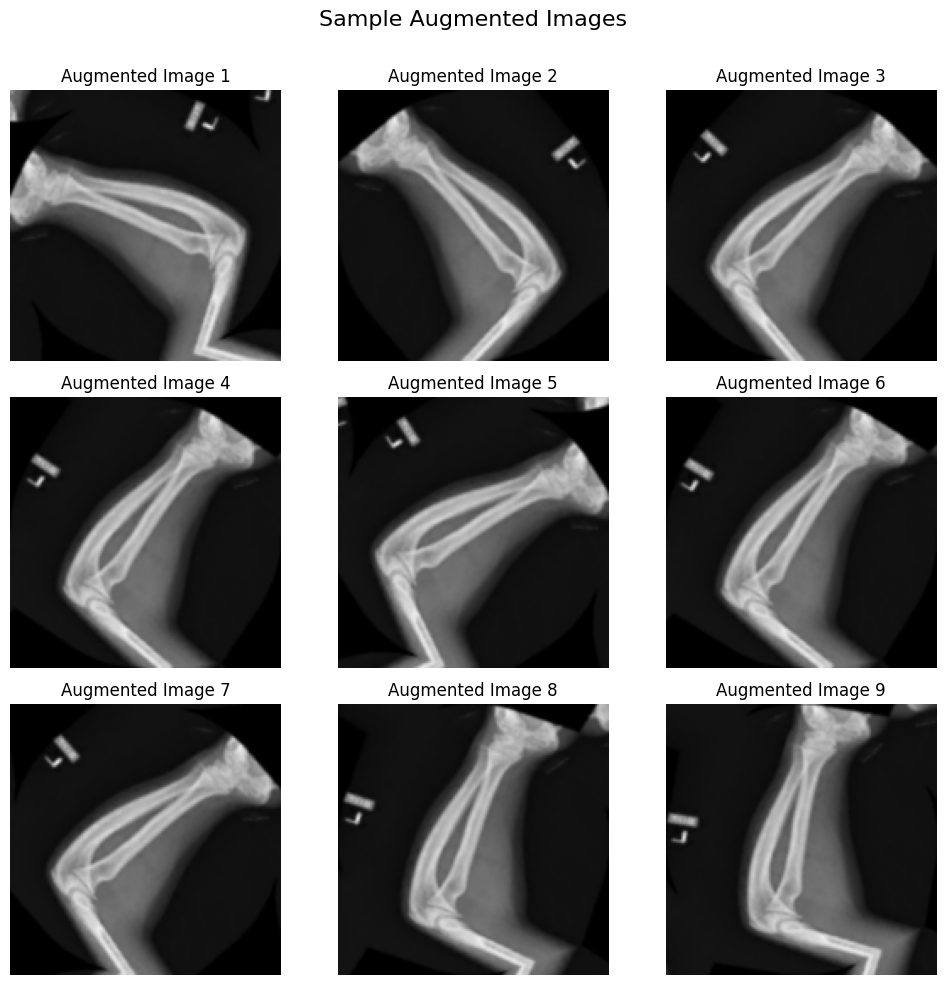

In [ ]:
# Visualize augmented images
augmented_images(train_dataset, data_augmentation)

In [ ]:
test_dataset.save('/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/data/tensor_dataset/test_dataset_mobilenet')

<h1 style="color: #00BFFF;">03 | Model training</h1>

<h4 style="color: #008080;">Transfer Learning with MobileNetV2</h4>

In [ ]:
# 3 for RGB
img_shape = img_size + (3,)

In [ ]:
img_shape

(160, 160, 3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False, # Exclude the ImageNet classifier at the top
                                               weights='imagenet') # Use the pre-trained weights from ImageNet

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False # Freeze the base model to keep the pre-trained weights

In [ ]:
# MobileNetV2 Structure
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

<h4 style="color: #FF6347;">Last Layers</h4>

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # layer object

# Apply the layer to MobileNetV2
x = global_average_layer(x)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # layer object
# Apply Fully Connected Layer to predict the class
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

<h2 style="color: #FF6347;">Training the Model</h2>

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8 # rate of decrease means 90% of the learning rate is decreased
)

In [ ]:
# Compile the model structure for training
base_learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

In [ ]:
# Define callbacks
drive_model_path = '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/models/best_model_mobilenet1.keras'

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=drive_model_path, monitor='val_loss', save_best_only=True)

In [ ]:
# Set the initial epochs
initial_epochs = 40

In [ ]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<h3 style="color: #FF8C00;">Training & Saving (Best Model + Metrics)</h3>

In [ ]:
import json

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=1  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Define the path to save the file in Google Drive
drive_path = '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/scripts/training_history1.json'

# Save the training history to Google Drive
with open(drive_path, 'w') as file:
    json.dump(history.history, file)

Epoch 1/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 671s 4s/step - accuracy: 0.6525 - loss: 0.6113 - val_accuracy: 0.8287 - val_loss: 0.3998
Epoch 2/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 55s 271ms/step - accuracy: 0.8435 - loss: 0.3831 - val_accuracy: 0.8591 - val_loss: 0.3509
Epoch 3/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 299ms/step - accuracy: 0.8663 - loss: 0.3374 - val_accuracy: 0.8773 - val_loss: 0.3290
Epoch 4/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 78s 270ms/step - accuracy: 0.8773 - loss: 0.3162 - val_accuracy: 0.8834 - val_loss: 0.3149
Epoch 5/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.8821 - loss: 0.3104 - val_accuracy: 0.8931 - val_loss: 0.3088
Epoch 6/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 295ms/step - accuracy: 0.8824 - loss: 0.3004 - val_accuracy: 0.8919 - val_loss: 0.3023
Epoch 7/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 78s 267ms/step - accuracy: 0.8875 - loss: 0.2981 - val_accuracy: 0.8919 - val_loss: 0.3017
Epoch 8/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.8893 - loss: 0.2

In [ ]:
# Load training history
with open(drive_path, 'r') as file:
    training_history = json.load(file)


In [ ]:
# Combine training and fine-tuning metrics
acc = training_history['accuracy']
val_acc = training_history['val_accuracy']

loss = training_history['loss']
val_loss = training_history['val_loss']

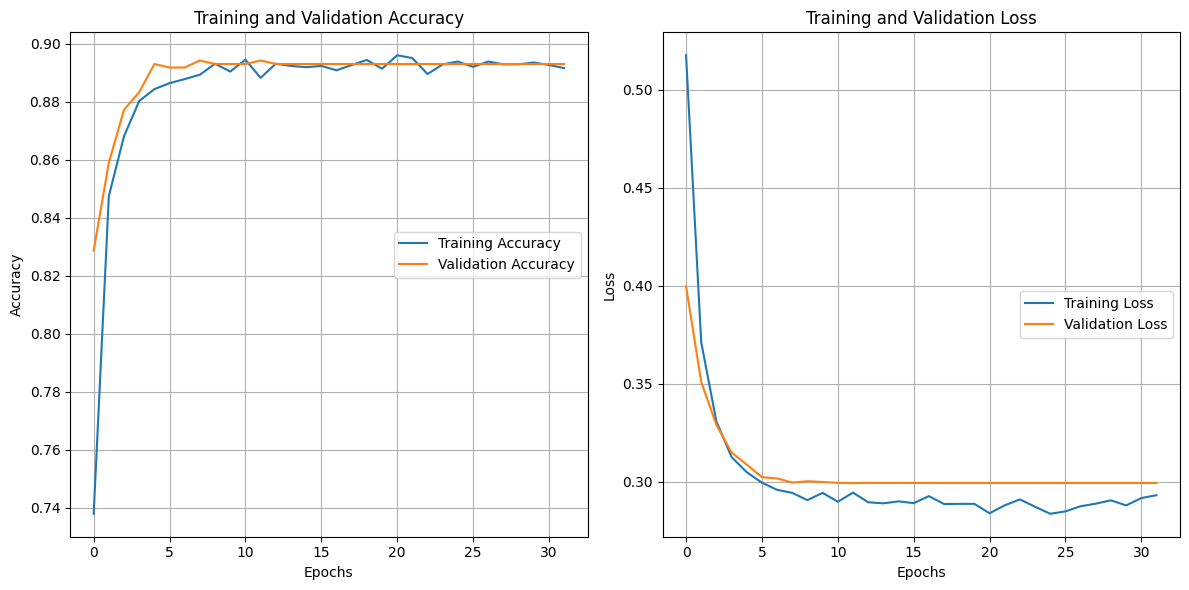

In [ ]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(15, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='#568ab9')
plt.plot(val_acc, label='Validation Accuracy', color='#f3e780')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='#568ab9')
plt.plot(val_loss, label='Validation Loss', color='#f3e780')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()